In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import folium
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

In [2]:
place_info = pd.read_csv('./data/meta/서울특별시 공공자전거 대여소 정보.csv')
place_info.head()

구명   대여소ID  대여소번호                      대여소명  \
0  강남구  ST-777   2301                현대고등학교 건너편   
1  강남구  ST-787   2302  교보타워 버스정류장(신논현역 3번출구 후면)   
2  강남구  ST-788   2303                  논현역 7번출구   
3  강남구  ST-789   2304         신영 ROYAL PALACE 앞   
4  강남구  ST-790   2305              MCM 본사 직영점 앞   

                              대여소 주소  거치대수         위도          경도  
0       서울특별시 강남구 압구정로 134현대고등학교 건너편    10  37.524071  127.021790  
1    서울특별시 강남구 봉은사로 지하 102교보타워 버스정류장    10  37.505581  127.024277  
2       서울특별시 강남구 학동로 지하 102논현역 7번출구    15  37.511517  127.021477  
3  서울특별시 강남구 언주로 626신영 ROYAL PALACE앞    10  37.512527  127.035835  
4      서울특별시 강남구 언주로 734MCM 본사 직영점 앞    10  37.520641  127.034508

In [3]:
location = place_info[['대여소 주소', '위도', '경도']].copy()
print(location.shape)
location.head()

(1460, 3)


대여소 주소         위도          경도
0       서울특별시 강남구 압구정로 134현대고등학교 건너편  37.524071  127.021790
1    서울특별시 강남구 봉은사로 지하 102교보타워 버스정류장  37.505581  127.024277
2       서울특별시 강남구 학동로 지하 102논현역 7번출구  37.511517  127.021477
3  서울특별시 강남구 언주로 626신영 ROYAL PALACE앞  37.512527  127.035835
4      서울특별시 강남구 언주로 734MCM 본사 직영점 앞  37.520641  127.034508

In [101]:
location_map = folium.Map(location=[37.566345, 126.977893], zoom_start=11)
location_map

In [102]:
location.apply(lambda row:folium.CircleMarker(location=[row["위도"], 
                                                  row["경도"]],
                                             radius = 2,
                                             opacity=0.5).add_to(location_map),
         axis=1)
location_map

### 서울시 25개 자치구니까 최소 > 25로

In [6]:
location[['위도', '경도']].head()

위도          경도
0  37.524071  127.021790
1  37.505581  127.024277
2  37.511517  127.021477
3  37.512527  127.035835
4  37.520641  127.034508

In [7]:
h_clust = linkage(location[['위도', '경도']], 'ward')
h_clust

array([[6.31000000e+02, 6.46000000e+02, 2.02002475e-04, 2.00000000e+00],
       [1.44900000e+03, 1.45500000e+03, 2.36985232e-04, 2.00000000e+00],
       [1.05700000e+03, 1.06800000e+03, 2.48394847e-04, 2.00000000e+00],
       ...,
       [2.91100000e+03, 2.91300000e+03, 1.32047870e+00, 5.98000000e+02],
       [2.91400000e+03, 2.91500000e+03, 1.90965979e+00, 8.62000000e+02],
       [2.91600000e+03, 2.91700000e+03, 4.07670842e+00, 1.46000000e+03]])

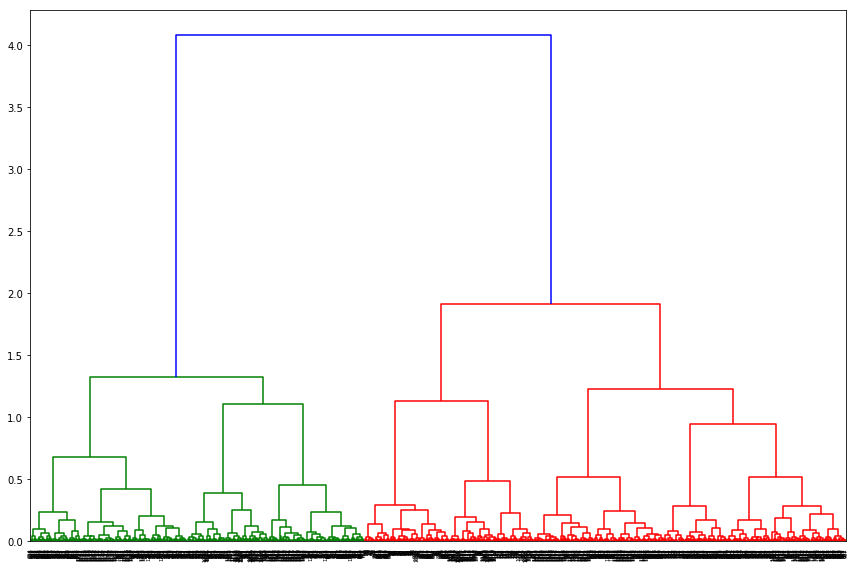

In [8]:
plt.figure(figsize = (12, 8))
rowdendr = dendrogram(h_clust, labels=[x for x in range(location.shape[0])])
plt.tight_layout()

In [9]:
clust = AgglomerativeClustering(n_clusters=500, affinity='euclidean')
groups = clust.fit_predict(location[['위도', '경도']])

In [10]:
len(groups)

1460

In [11]:
location['groups'] = groups

In [12]:
location.head()

대여소 주소         위도          경도  groups
0       서울특별시 강남구 압구정로 134현대고등학교 건너편  37.524071  127.021790       5
1    서울특별시 강남구 봉은사로 지하 102교보타워 버스정류장  37.505581  127.024277      45
2       서울특별시 강남구 학동로 지하 102논현역 7번출구  37.511517  127.021477      54
3  서울특별시 강남구 언주로 626신영 ROYAL PALACE앞  37.512527  127.035835      95
4      서울특별시 강남구 언주로 734MCM 본사 직영점 앞  37.520641  127.034508     194

In [13]:
group_loc = location.groupby(groups).mean()
group_loc.head()

위도          경도  groups
0  37.574586  127.037137       0
1  37.581654  126.883304       1
2  37.571759  127.006948       2
3  37.476848  126.982848       3
4  37.455194  127.055583       4

In [14]:
group_N = location.groupby(groups).count()['groups']
group_N.head()

0    7
1    5
2    7
3    5
4    3
Name: groups, dtype: int64

In [15]:
group_loc['counts'] = group_N
group_loc.head()

위도          경도  groups  counts
0  37.574586  127.037137       0       7
1  37.581654  126.883304       1       5
2  37.571759  127.006948       2       7
3  37.476848  126.982848       3       5
4  37.455194  127.055583       4       3

In [16]:
group_loc['위도']=round(group_loc['위도'],6)
group_loc['경도']=round(group_loc['경도'],6)

In [17]:
group_loc.dtypes

위도        float64
경도        float64
groups      int64
counts      int64
dtype: object

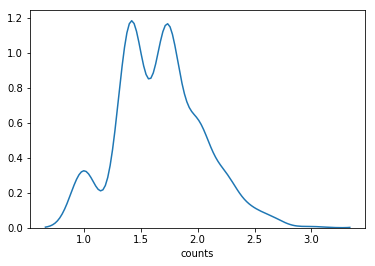

In [18]:
sns.distplot(np.sqrt(group_loc.counts), hist=False)

In [103]:
group_loc.apply(lambda row:folium.CircleMarker(location=[row["위도"], row["경도"]],
                                               radius = 3*np.sqrt(row["counts"]),
                                               color='crimson',
                                               fill=True,
                                               fill_opacity=0.3,
                                               opacity=0.6
                                              ).add_to(location_map),
               axis=1)
location_map

In [20]:
place_group = location.copy()
place_group.head()

대여소 주소         위도          경도  groups
0       서울특별시 강남구 압구정로 134현대고등학교 건너편  37.524071  127.021790       5
1    서울특별시 강남구 봉은사로 지하 102교보타워 버스정류장  37.505581  127.024277      45
2       서울특별시 강남구 학동로 지하 102논현역 7번출구  37.511517  127.021477      54
3  서울특별시 강남구 언주로 626신영 ROYAL PALACE앞  37.512527  127.035835      95
4      서울특별시 강남구 언주로 734MCM 본사 직영점 앞  37.520641  127.034508     194

In [21]:
place_group['대여소번호'] = place_info['대여소번호']
place_group['구명'] = place_info['구명']
place_group.head()

대여소 주소         위도          경도  groups  대여소번호  \
0       서울특별시 강남구 압구정로 134현대고등학교 건너편  37.524071  127.021790       5   2301   
1    서울특별시 강남구 봉은사로 지하 102교보타워 버스정류장  37.505581  127.024277      45   2302   
2       서울특별시 강남구 학동로 지하 102논현역 7번출구  37.511517  127.021477      54   2303   
3  서울특별시 강남구 언주로 626신영 ROYAL PALACE앞  37.512527  127.035835      95   2304   
4      서울특별시 강남구 언주로 734MCM 본사 직영점 앞  37.520641  127.034508     194   2305   

    구명  
0  강남구  
1  강남구  
2  강남구  
3  강남구  
4  강남구

In [22]:
place_group = place_group.reindex(columns=['구명', '대여소번호', '대여소 주소', 'groups', '위도', '경도'])
place_group.head()

구명  대여소번호                             대여소 주소  groups         위도  \
0  강남구   2301       서울특별시 강남구 압구정로 134현대고등학교 건너편       5  37.524071   
1  강남구   2302    서울특별시 강남구 봉은사로 지하 102교보타워 버스정류장      45  37.505581   
2  강남구   2303       서울특별시 강남구 학동로 지하 102논현역 7번출구      54  37.511517   
3  강남구   2304  서울특별시 강남구 언주로 626신영 ROYAL PALACE앞      95  37.512527   
4  강남구   2305      서울특별시 강남구 언주로 734MCM 본사 직영점 앞     194  37.520641   

           경도  
0  127.021790  
1  127.024277  
2  127.021477  
3  127.035835  
4  127.034508

In [23]:
# place_group.to_csv('./data/place_group.csv', index=False)

# After commute analysis

In [25]:
commute_up20 = pd.read_csv('./data/commute_up20.csv')
commute_down20 = pd.read_csv('./data/commute_down20.csv')

In [127]:
commute_up20.head()

대여소그룹  반납소그룹    횟수
0    271    432  1396
1    400     12  1109
2    102    310  1060
3      9    116   910
4     77    432   724

In [128]:
commute_up_loc = pd.merge(commute_up20, group_loc.drop(['counts'], axis=1), how='inner', left_on='대여소그룹', right_on='groups').drop(
    ['groups'], axis=1).rename(columns={'위도':'대여소위도', '경도':'대여소경도'})
commute_up_loc.head()

대여소그룹  반납소그룹    횟수      대여소위도       대여소경도
0    271    432  1396  37.546236  127.057231
1    271    360   405  37.546236  127.057231
2    400     12  1109  37.577118  126.895426
3    102    310  1060  37.530784  127.077352
4      9    116   910  37.567232  126.916162

In [129]:
commute_up_loc = pd.merge(commute_up_loc, group_loc.drop(['counts'], axis=1), how='inner', left_on='반납소그룹', right_on='groups').drop(
    ['groups'], axis=1).rename(columns={'위도':'반납소위도', '경도':'반납소경도'})
commute_up_loc.head()

대여소그룹  반납소그룹    횟수      대여소위도       대여소경도      반납소위도       반납소경도
0    271    432  1396  37.546236  127.057231  37.548100  127.062420
1     77    432   724  37.549473  127.074102  37.548100  127.062420
2    271    360   405  37.546236  127.057231  37.538231  127.054039
3    400     12  1109  37.577118  126.895426  37.576434  126.889766
4     66     12   484  37.575802  126.900822  37.576434  126.889766

### commute up visualization

In [130]:
location_map = folium.Map(location=[37.566345, 126.977893], zoom_start=11)

In [131]:
location.apply(lambda row:folium.CircleMarker(location=[row["위도"], 
                                                  row["경도"]],
                                             radius = 2,
                                             opacity=0.5).add_to(location_map),
         axis=1)

group_loc.apply(lambda row:folium.CircleMarker(location=[row["위도"], row["경도"]],
                                               radius = 3*np.sqrt(row["counts"]),
                                               color='crimson',
                                               fill=True,
                                               fill_opacity=0.3,
                                               opacity=0.6
                                              ).add_to(location_map),
               axis=1)
location_map

In [132]:
commute_up_loc.apply(lambda row:folium.PolyLine(locations=[[row["대여소위도"], row["대여소경도"]], 
                                                           [row["반납소위도"], row["반납소경도"]]],
                                                color='green',
                                               tooltip=row["대여소그룹"].astype(int).astype(str) + "_" + row["반납소그룹"].astype(int).astype(str)).add_to(location_map),
               axis=1)

commute_up_loc.apply(lambda row:folium.RegularPolygonMarker(location=[row["반납소위도"], row["반납소경도"]],
                                                            color='black',
                                                            fill_color='grey',
                                                            fill_opacity=0.7,
                                                            number_of_sides=6,
                                                            radius=5).add_to(location_map),
               axis=1)
location_map

In [133]:
commute_down20.head()

대여소그룹  반납소그룹   횟수
0    432    271  770
1     12    400  613
2    116      9  565
3    310    102  538
4    191    178  518

In [134]:
commute_down_loc = pd.merge(commute_down20, group_loc.drop(['counts'], axis=1), how='inner', left_on='대여소그룹', right_on='groups').drop(
    ['groups'], axis=1).rename(columns={'위도':'대여소위도', '경도':'대여소경도'})
commute_down_loc.head()

대여소그룹  반납소그룹   횟수      대여소위도       대여소경도
0    432    271  770  37.548100  127.062420
1     12    400  613  37.576434  126.889766
2     12     66  245  37.576434  126.889766
3    116      9  565  37.557831  126.925115
4    310    102  538  37.533256  127.067696

In [135]:
commute_down_loc = pd.merge(commute_down_loc, group_loc.drop(['counts'], axis=1), how='inner', left_on='반납소그룹', right_on='groups').drop(
    ['groups'], axis=1).rename(columns={'위도':'반납소위도', '경도':'반납소경도'})
commute_down_loc.head()

대여소그룹  반납소그룹   횟수      대여소위도       대여소경도      반납소위도       반납소경도
0    432    271  770  37.548100  127.062420  37.546236  127.057231
1     12    400  613  37.576434  126.889766  37.577118  126.895426
2      1    400  290  37.581654  126.883304  37.577118  126.895426
3     12     66  245  37.576434  126.889766  37.575802  126.900822
4    116      9  565  37.557831  126.925115  37.567232  126.916162

### commute down visualization

In [136]:
location_map = folium.Map(location=[37.566345, 126.977893], zoom_start=11)

In [137]:
location.apply(lambda row:folium.CircleMarker(location=[row["위도"], 
                                                  row["경도"]],
                                             radius = 2,
                                             opacity=0.5).add_to(location_map),
         axis=1)

group_loc.apply(lambda row:folium.CircleMarker(location=[row["위도"], row["경도"]],
                                               radius = 3*np.sqrt(row["counts"]),
                                               color='crimson',
                                               fill=True,
                                               fill_opacity=0.3,
                                               opacity=0.6
                                              ).add_to(location_map),
               axis=1)
location_map

In [138]:
commute_down_loc.apply(lambda row:folium.PolyLine(locations=[[row["대여소위도"], row["대여소경도"]], 
                                                           [row["반납소위도"], row["반납소경도"]]],
                                                color='green',
                                               tooltip=row["대여소그룹"].astype(int).astype(str) + "_" + row["반납소그룹"].astype(int).astype(str)).add_to(location_map),
               axis=1)

commute_down_loc.apply(lambda row:folium.RegularPolygonMarker(location=[row["반납소위도"], row["반납소경도"]],
                                                            color='black',
                                                            fill_color='grey',
                                                            fill_opacity=0.7,
                                                            number_of_sides=6,
                                                            radius=5).add_to(location_map),
               axis=1)
location_map